In [1]:
from scipy.stats import truncnorm
import pandas as pd
import numpy as np
import itertools
import datetime
import tqdm
import sys
import os

def flatten_list(list_array):
    return list(itertools.chain(*list_array))

sys.path.insert(0, "../")
sys.path.insert(0,"../pompjax/pompjax/")

from global_config import config

results_dir           = config.get_property('results_dir')
results2_dir           = config.get_property('results2_dir')

data_dir              = config.get_property('data_dir')
paper_dir             = config.get_property('paper_dir')
data_db_dir           = config.get_property('data_db_dir')
feb_hosp_records_path = os.path.join(data_db_dir, 'long_files_8_25_2021')
path_to_save          = os.path.join(results_dir, "real_testing", "community")

COLOR_LIST1           = ["#F8AFA8", "#FDDDA0", "#F5CDB4", "#74A089"]

# pompjax imports
from utils_local.misc import amro2title, amro2cute
import matplotlib.pyplot as plt

from eval.calibration import calibration
from utils import create_df_response


In [2]:
from utils_data_metapop import create_population_data, create_time_transfers

path_to_ward_counts = os.path.join(data_db_dir, "long_files_8_25_2021", "counts_ward.csv" )
path_to_ward_transf = os.path.join(data_db_dir, "long_files_8_25_2021", "transfers_ward.csv" )

A_df, D_df, H_df, tests_df, Hmean_df = create_population_data(path_to_ward_counts)

num_wards  = len(Hmean_df)
ward_names = list(Hmean_df.index)
M_df       = create_time_transfers(path_to_ward_transf, num_wards=num_wards, ward_names=ward_names)

selected_buildings = ['Allen Hospital-Allen', 'Harkness Pavilion-Columbia', 'Milstein Hospital-Columbia', 'Mschony-Chony', 'Presbyterian Hospital-Columbia']
building2id        = {selected_buildings[i]: i for i in range(len(selected_buildings))}

def building2observation(building):
    if building in selected_buildings:
        return building2id[building]
    else:
        return 5

ward_names_df                = pd.DataFrame(ward_names, columns=["ward"])
ward_names_df["building"]    = ward_names_df["ward"].apply(lambda x: "-".join(x.split("-")[1:]))
ward_names_df["buidling_id"] = ward_names_df["building"].apply(lambda x: building2observation(x) )
ward_names_df["ward_id"]     = ward_names_df.apply(lambda x: np.where(ward_names_df.ward == x.ward)[0][0], axis=1)
wardid2buildingid            = {row.ward_id: row.buidling_id for i, row in ward_names_df.iterrows()}


from models import process_metapop, observe_metapop_cluster, init_metapop, simulate_metapop, simulate_metapop_observations
from utils_local.misc import amro2cute

delta = 1/120  # decolonization rate
A     = A_df.to_numpy()
D     = D_df.to_numpy()
H     = H_df.to_numpy()
M     = M_df
tests = tests_df.to_numpy()


In [3]:
#### create scenarios ####
amro_search  = ['ESCHERICHIA COLI', 'KLEBSIELLA PNEUMONIAE',  'PSEUDOMONAS AERUGINOSA',
            'METHICILLIN-SUSCEPTIBLE STAPHYLOCOCCUS AUREUS', 'METHICILLIN-RESISTANT STAPHYLOCOCCUS AUREUS',
            "STAPHYLOCOCCUS EPIDERMIDIS", 'ENTEROCOCCUS FAECALIS', 'ENTEROCOCCUS FAECIUM']

path_to_scenarios = os.path.join(results2_dir, "synthetic_inferences", "metapopulation")


## calibration not adjusting the state space

In [4]:
dates_simulation = pd.date_range(start=pd.to_datetime("2020-02-01"), end=pd.to_datetime("2021-02-28"), freq="D")
num_pop          = num_wards

model_settings = {
                "n"              : 3 * num_pop,           # number of state variables / dimension of the state space
                "T"              : len(dates_simulation),  # time to run
                "num_pop"        : num_pop,
                "dates"          : dates_simulation,
                "num_build"      : len(np.unique(list(wardid2buildingid.values()))),
                "k"              : len(np.unique(list(wardid2buildingid.values()))) # observing at the building aggregation
                }

In [5]:
from utils_data_metapop import empirical_prevalence
from pyro.ops.stats import crps_empirical
from tqdm import tqdm
import torch

for idx_amro, amro in enumerate(amro_search[::-1]):
    print("Running IF-EAKF for amro: ", amro2title(amro))
    path_to_save = os.path.join(results2_dir, "synthetic_inferences", "metapopulation", f"{amro2cute(amro)}")
    scenarios_df = pd.read_csv(os.path.join(path_to_save, "scenarios.csv"))

    gamma        = empirical_prevalence(amro, path_to_prev="../data/amro_prevalence.csv")

    calibration_df = pd.DataFrame()
    error_df       = pd.DataFrame()

    if os.path.isfile(os.path.join(path_to_save, "no_adjust_state_space", "calibration.csv")):
        continue

    for idx_row, row in tqdm(scenarios_df.iterrows(), total=len(scenarios_df)):
        inference = np.load(os.path.join(path_to_save, "no_adjust_state_space",
                                        f"scenario{idx_row+1}", f"{str(0).zfill(3)}posterior.npz"))

        θmle      = inference["mle"]
        θpost     = inference["posterior"]
        x_sim     = inference["state_space"]
        y_sim     = inference["observations"]
        θtruth    = inference["teta_truth"]
        idx_infer = inference["idx_infer"]
        Nif       = θpost.shape[-1]

        model_settings["m"] = θpost.shape[1]

        f0  = lambda θ:  init_metapop(N0               = H[:, 0],
                                        c0             = gamma,
                                        model_settings = model_settings)

        f  = lambda t, x, θ: process_metapop(t, x,
                                                gamma = gamma * np.ones(model_settings["m"]),
                                                beta  = θ[1, :],
                                                delta = delta,
                                                Nmean = np.expand_dims(Hmean_df, -1),
                                                N     = H[:, [t]],
                                                A     = A[:, [t]],
                                                D     = D[:, [t]],
                                                M     = M[:, :, t])

        g = lambda t, x, θ: observe_metapop_cluster(t, x,
                                                    rho            = θ[0, :],
                                                    N              = H[:, [t]],
                                                    num_tests      = tests[:, [t]],
                                                    model_settings = model_settings,
                                                    ward2cluster   = wardid2buildingid)

        observation = np.sum(y_sim[:, :, idx_infer].transpose(1, 0), axis=0, keepdims=True)

        θpost = np.mean(θpost, -2)

        truth               = np.squeeze(np.expand_dims(θtruth[:,0], -1)* np.ones((1, 1, Nif)))
        error               = np.array(crps_empirical(torch.tensor(θpost.transpose(1, 0, 2)), torch.tensor(truth)))
        err_df              = pd.DataFrame(columns=["value", "variable", "parameter", "scenario", "amro"])
        err_df["value"]      = list(error[0, :]) + list(error[1, :])
        err_df["parameter"] = list(["rho"]*Nif) + list(["beta"]*Nif)
        err_df["scenario"]  = f"scenario{idx_row+1}"
        err_df["variable"]  = f"crps"
        err_df["amro"]      = amro

        error_df            = pd.concat([error_df, err_df])

        for if_iter in range(Nif):
            θsim           = θpost[:, :, if_iter]
            x_sim, obs_sim = simulate_metapop(process_model     = f,
                                            observational_model = g,
                                            init_state          = f0,
                                            θsim                = θsim,
                                            model_settings      = model_settings)

            obs_sim                    = np.sum(obs_sim.transpose(1, 0, 2) , axis=0, keepdims=True)
            cal_df                     = calibration(obs_sim, observation, observation_index=0, dates=model_settings["dates"])
            cal_df["if_iter"]          = if_iter
            cal_df["score"]            = np.mean(np.abs(cal_df.quantiles.values - cal_df.proportion_inside.values))
            cal_df["scenario"]         = f"scenario{idx_row+1}"
            cal_df["amro"]             = amro
            calibration_df             = pd.concat([calibration_df, cal_df])

    calibration_df.to_csv(os.path.join(path_to_save, "no_adjust_state_space", "calibration.csv"), index=False)
    error_df.to_csv(os.path.join(path_to_save, "no_adjust_state_space", "param_error.csv"), index=False)


/Users/chaosdonkey06/anaconda3/envs/pompjax/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Running IF-EAKF for amro:  E. faecium
Running IF-EAKF for amro:  E. faecalis
Running IF-EAKF for amro:  S. epidermidis
Running IF-EAKF for amro:  MRSA
Running IF-EAKF for amro:  MSSA
Running IF-EAKF for amro:  P. aeruginosa
Running IF-EAKF for amro:  K. pneumoniae
Running IF-EAKF for amro:  E. coli


In [9]:

#for idx_amro, amro in enumerate(amro_search):
amro = amro_search[0]

print("Running IF-EAKF for amro: ", amro2title(amro))
path_to_save   = os.path.join(results2_dir, "synthetic_inferences", "metapopulation", f"{amro2cute(amro)}")
scenarios_df   = pd.read_csv(os.path.join(path_to_save, "scenarios.csv"))

gamma          = empirical_prevalence(amro, path_to_prev="../data/amro_prevalence.csv")
calibration_df = pd.read_csv(os.path.join(path_to_save, "no_adjust_state_space", "calibration.csv"))
mean_cal_df    = calibration_df.groupby(["scenario", "if_iter"]).mean().reset_index()


Running IF-EAKF for amro:  E. coli


/var/folders/7p/jp6xqkvn5wb6ddl1fn0bhs980000gn/T/ipykernel_45811/1740696059.py:11: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  mean_cal_df = calibration_df.groupby(["scenario", "if_iter"]).mean().reset_index()


Text(0.5, 0.98, 'Average calibration error for synthetic data')

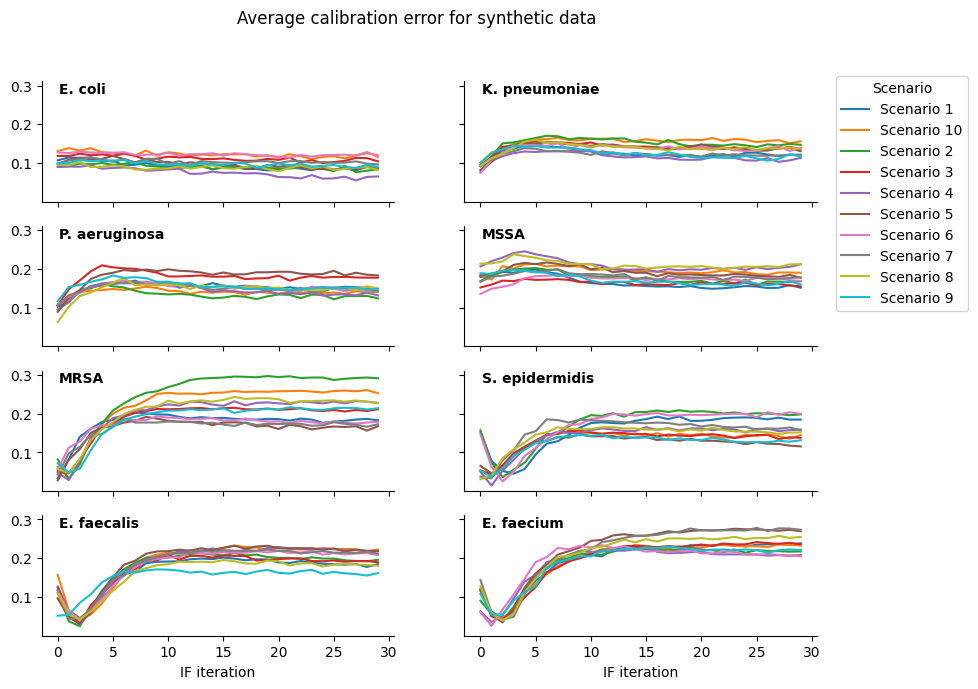

In [67]:
import seaborn as sns
fig, axes = plt.subplots(4, 2, figsize=(10, 7.2), sharex=True, sharey=True)

for idx_amro, ax in enumerate(axes.flatten()):
    amro = amro_search[idx_amro]
    path_to_save   = os.path.join(results2_dir, "synthetic_inferences", "metapopulation", f"{amro2cute(amro)}")

    calibration_df              = pd.read_csv(os.path.join(path_to_save, "no_adjust_state_space", "calibration.csv"))
    mean_cal_df                 = calibration_df.groupby(["scenario", "if_iter"]).mean(numeric_only=True).reset_index()
    mean_cal_df["scenario_plt"] = mean_cal_df["scenario"].apply(lambda x: x.replace("scenario", "Scenario "))

    sns.lineplot(ax=ax, data=mean_cal_df, x="if_iter", y="score", hue="scenario_plt", style="scenario_plt", markers=False, dashes=False, palette="tab10")

    ax.text(x=0.1, y=0.28, s=f"{amro2title(amro)}", weight='bold')
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.legend().remove()
    ax.set_ylabel(None)

axes[0, 1].legend(title="Scenario", loc="upper right", bbox_to_anchor=(1.45, 1.1), ncol=1)
axes[0, -1].set_xlabel("IF iteration")
axes[1, -1].set_xlabel("IF iteration")

axes[-1, 0].set_xlabel("IF iteration")
axes[-1, 1].set_xlabel("IF iteration")

fig.suptitle("Average calibration error for synthetic data")


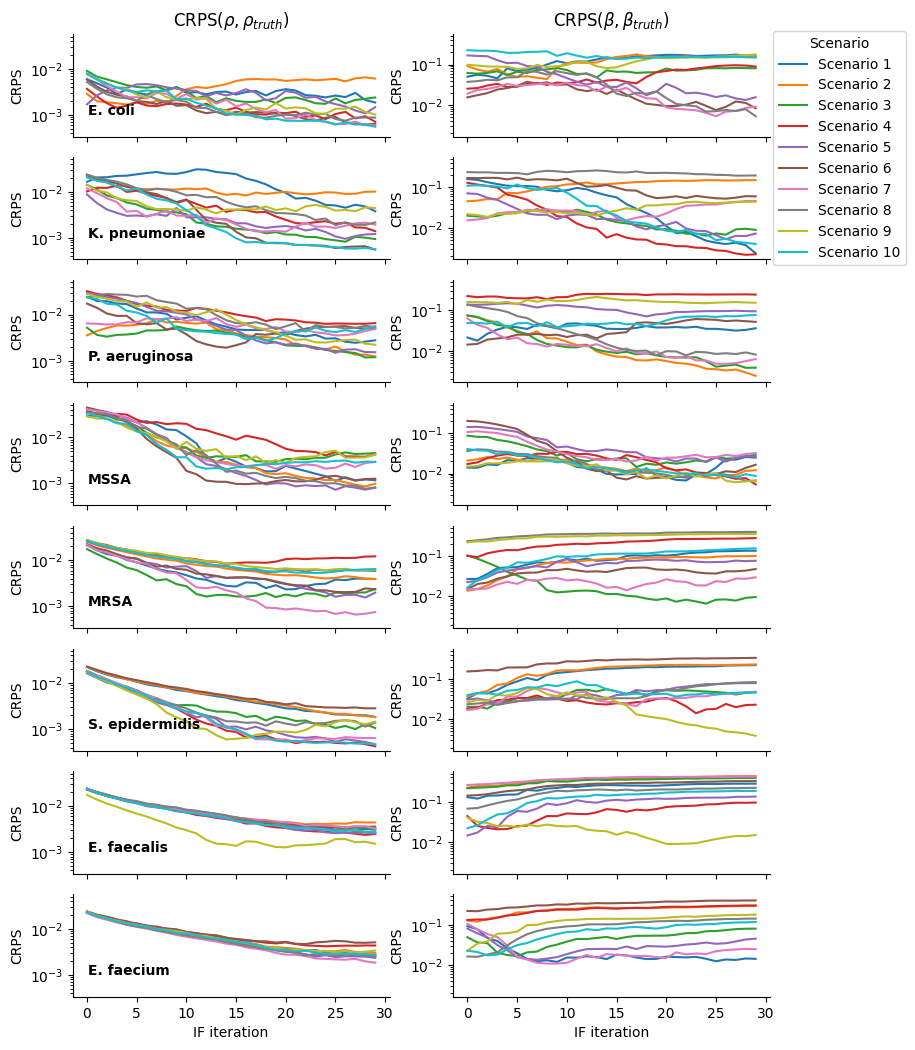

In [79]:
fig, axes = plt.subplots(len(amro_search), 2, figsize=(9, 12.5), sharex=True, sharey="col")

for idx_amro, amro in enumerate(amro_search):
    path_to_save               = os.path.join(results2_dir, "synthetic_inferences", "metapopulation", f"{amro2cute(amro)}")
    p_error_df                 = pd.read_csv(os.path.join(path_to_save, "no_adjust_state_space", "param_error.csv"))
    p_error_df["if_iter"]      = flatten_list([range(30)] * int(len(p_error_df) / 30))
    p_error_df["scenario_plt"] = p_error_df["scenario"].apply(lambda x: x.replace("scenario", "Scenario "))

    sns.lineplot(ax=axes[idx_amro, 0], data=p_error_df[p_error_df.parameter=="rho"], x="if_iter", y="value", hue="scenario_plt",   palette="tab10", legend=False)
    sns.lineplot(ax=axes[idx_amro, 1], data=p_error_df[p_error_df.parameter=="beta"], x="if_iter", y="value", hue="scenario_plt",  palette="tab10", legend=True)
    axes[idx_amro, 0].spines['right'].set_visible(False); axes[idx_amro, 1].spines['right'].set_visible(False)
    axes[idx_amro, 0].spines['top'].set_visible(False); axes[idx_amro, 1].spines['top'].set_visible(False)

    axes[idx_amro, 0].text(x=0.1, y=0.001, s=f"{amro2title(amro)}", weight='bold')
    axes[idx_amro, 1].legend().remove()

    axes[idx_amro, 0].set_ylabel(r"CRPS")
    axes[idx_amro, 1].set_ylabel(r"CRPS")

    axes[idx_amro, 0].set_yscale("log")
    axes[idx_amro, 1].set_yscale("log")

axes[0, 0].set_title(r"CRPS$\left(\rho, \rho_{{truth}}\right)$")
axes[0, 1].set_title(r"CRPS$\left(\beta, \beta_{{truth}}\right)$")

axes[-1, 0].set_xlabel("IF iteration")
axes[-1, 1].set_xlabel("IF iteration")
axes[0, 1].legend(title="Scenario", loc="upper right", bbox_to_anchor=(1.45, 1.1), ncol=1)
#plt.tight_layout()
